# Nemesis English Dataset — Exploration Notebook

This notebook explores the **English darknet market dataset** consisting of text files:

- `00000.txt` … `01333.txt`  
- Each file is a **single product / listing page** scraped from the Nemesis Market.

You can use this notebook to:

- Load and inspect all `.txt` files
- Parse basic metadata (title, category, seller, rating, price, etc.) using simple regular expressions
- Build a structured `DataFrame` for further analysis
- Compute simple statistics and visualizations

> **Instructions:**  
> 1. Set `DATA_DIR` below to the folder containing all your `00000.txt`–`01333.txt` files.  
> 2. Run the cells from top to bottom.


In [3]:
import os
import glob
import re
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Show plots inline (if you run this in Jupyter)
%matplotlib inline

# === Configure your dataset path here ===
# Example: if your txt files are in the same folder as this notebook, use "."
# Example: if they are in a folder called "textpages", use "./textpages"
DATA_DIR = Path("./textpages")

# Pattern to match all Nemesis txt files
TXT_PATTERN = "0*.txt"  # covers 00000.txt ... 01333.txt
files = sorted(DATA_DIR.glob(TXT_PATTERN))

print(f"Found {len(files)} txt files in {DATA_DIR.resolve()}")
if len(files) > 0:
    print("First 5 files:")
    for f in files[:5]:
        print("  -", f.name)


Found 1334 txt files in C:\Users\Nguyen Ngo\Downloads\English\English\textpages
First 5 files:
  - 00000.txt
  - 00001.txt
  - 00002.txt
  - 00003.txt
  - 00004.txt


In [4]:
def read_text(path: Path) -> str:
    """Read a text file as UTF-8 with fallback, return as a string."""
    try:
        return path.read_text(encoding="utf-8", errors="replace")
    except Exception as e:
        print(f"[WARN] Failed to read {path}: {e}")
        return ""

# Quick inspection of one sample file
if files:
    sample_text = read_text(files[0])
    print("=== Sample file:", files[0].name, "===\n")
    print("\n".join(sample_text.splitlines()[:60]))


=== Sample file: 00000.txt ===

URL: http://nemesis555nchzn2dogee6mlc7xxgeeshqirmh3yzn4lo5cnd4s5a4yd.onion/item/m9bgov81hz
TIMESTAMP: 2023-01-11T13:00:52
TITLE: USA FULLZ + DL + BACKGROUND REPORT MONTANA | Nemesis Market
TEXT:
USA FULLZ + DL + BACKGROUND REPORT MONTANA | Nemesis Market   * !Nemesis Market(/assets/media/logos/logo.png)
  * Market 
  * Forum 
  *   * Sign in 
  * Create an Account 

  * Drugs 
    * Cannabis 2531
      * Buds and Flowers 1858
      * Concentrates 153
      * Cartridges 35
      * Pre-rolls 2
      * Edibles 181
      * Hash 178
      * Seeds 17
      * Shake 47
      * Synthetics 12
      * Syrup 4
      * Other 44
    * Stimulants 1251
      * Cocaine 650
      * Crack 28
      * Methamphetamine (Meth) 123
      * Amphetamine/Speed 144
      * Adderall 153
      * Mephedrone 34
      * Methylphenidate 20
      * Lidocaine 4
      * Khat 4
      * Sexual Stimulants 43
      * Other 48
    * Opioids 498
      * Heroin 115
      * Oxycodone 176
      * Bup

In [11]:
TITLE_RE = re.compile(r"^\s*(.+?)\s*\|\s*Nemesis Market\s*$")
CATEGORY_RE = re.compile(r"^\s*(Drugs|Fraud|Hacking|Forgeries/Counterfeits|Other)\s*»\s*(.+)$")
SELLER_RE = re.compile(r"^\s*([A-Za-z0-9_\-]+)\s*$")
RATING_RE = re.compile(r"Rating:\s*([\d.]+)\s*out of 5", re.IGNORECASE)
REVIEWS_RE = re.compile(r"Reviews:\s*(\d+)", re.IGNORECASE)
SALES_RE = re.compile(r"Sales:\s*(\d+)", re.IGNORECASE)
PRICE_LINE_RE = re.compile(r"(\d+(?:\.\d+)?)\s*(USD|EUR|GBP)", re.IGNORECASE)
TIMESTAMP_RE = re.compile(r"(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2} UTC)")
URL_RE = re.compile(r"(nemesis[0-9a-z]+\.onion[^\s]*)")

def parse_listing(text: str, filename: str) -> dict:
    \"\"\"Heuristic parser for a single Nemesis listing page.

    This function is **best-effort** only. It tries to extract:
    - title
    - root_category, subcategory
    - seller
    - rating, reviews, sales
    - prices (min, max)
    - currency
    - url, timestamp (if present)
    - basic length stats
    \"\"\"
    lines = [ln.rstrip() for ln in text.splitlines()]
    non_empty = [ln for ln in lines if ln.strip()]
    
    title = None
    root_category = None
    subcategory = None
    seller = None
    rating = None
    reviews = None
    sales = None
    currency = None
    price_min = None
    price_max = None
    url = None
    timestamp = None

    # --- Title (first non-empty line usually) ---
    if non_empty:
        # Try Nemesis-style title first
        m = TITLE_RE.match(non_empty[0])
        if m:
            title = m.group(1).strip()
        else:
            # fallback: just use first line
            title = non_empty[0].strip()

    # --- Category & seller block ---
    for i, ln in enumerate(non_empty):
        # Category
        m_cat = CATEGORY_RE.match(ln)
        if m_cat and not root_category:
            root_category = m_cat.group(1).strip()
            subcategory = m_cat.group(2).strip()
        # Seller block heuristic: line with avatar next, rating, etc.
        if "Rating:" in ln and i > 0 and seller is None:
            prev = non_empty[i-1].strip()
            # Many pages have seller name on previous line (just the nick)
            if prev and "!" not in prev and "Escrow" not in prev and "You may be interested" not in prev:
                seller = prev

    # --- Rating, reviews, sales ---
    m_rating = RATING_RE.search(text)
    if m_rating:
        try:
            rating = float(m_rating.group(1))
        except ValueError:
            rating = None

    m_reviews = REVIEWS_RE.search(text)
    if m_reviews:
        reviews = int(m_reviews.group(1))

    m_sales = SALES_RE.search(text)
    if m_sales:
        sales = int(m_sales.group(1))

    # --- Prices & currency ---
    prices = []
    for m in PRICE_LINE_RE.finditer(text):
        val = float(m.group(1))
        cur = m.group(2).upper()
        prices.append(val)
        currency = cur  # last seen currency

    if prices:
        price_min = float(np.min(prices))
        price_max = float(np.max(prices))

    # --- URL & timestamp (if present in header) ---
    m_ts = TIMESTAMP_RE.search(text)
    if m_ts:
        timestamp = m_ts.group(1)

    m_url = URL_RE.search(text)
    if m_url:
        url = m_url.group(1)

    # --- Basic text stats ---
    n_chars = len(text)
    n_words = len(text.split())

    # --- Simple keyword-based high-level type ---
    t_lower = text.lower()
    if any(k in t_lower for k in ["cannabis", "cocaine", "heroin", "mdma", "lsd", "weed", "marijuana"]):
        high_level_type = "drugs_or_related"
    elif any(k in t_lower for k in ["fullz", "ssn", "dob", "background report", "carding"]):
        high_level_type = "fraud_or_identity"
    elif any(k in t_lower for k in ["tutorial", "guide", "method", "how to"]):
        high_level_type = "guide_or_tutorial"
    else:
        high_level_type = "other"

    return {
        "filename": filename,
        "title": title,
        "root_category": root_category,
        "subcategory": subcategory,
        "seller": seller,
        "rating": rating,
        "reviews": reviews,
        "sales": sales,
        "currency": currency,
        "price_min": price_min,
        "price_max": price_max,
        "url": url,
        "timestamp": timestamp,
        "n_chars": n_chars,
        "n_words": n_words,
        "high_level_type": high_level_type,
    }


In [7]:
records = []

for path in files:
    txt = read_text(path)
    if not txt:
        continue
    rec = parse_listing(txt, path.name)
    records.append(rec)

df = pd.DataFrame(records)
print(f"Parsed {len(df)} listings.")


# Basic preview
df.head()


Parsed 1334 listings.


,filename,title,root_category,subcategory,seller,rating,reviews,sales,currency,price_min,price_max,url,timestamp,n_chars,n_words,high_level_type
0,00000.txt,URL: http://nemesis555nchzn2dogee6mlc7xxgeeshq...,Fraud,SSN/DOB/DL/PII,victorviran,4.9,296,4627,USD,4.99,219.0,nemesis555nchzn2dogee6mlc7xxgeeshqirmh3yzn4lo5...,2023-01-11 03:36:24 UTC,9378,1355,drugs_or_related
1,00001.txt,URL: http://nemesis555nchzn2dogee6mlc7xxgeeshq...,Drugs,Cannabis » Seeds,greenpirate,4.5,20,62,GBP,2.00,588.0,nemesis555nchzn2dogee6mlc7xxgeeshqirmh3yzn4lo5...,2023-01-11 03:24:18 UTC,10712,1391,drugs_or_related
2,00002.txt,URL: http://nemesis555nchzn2dogee6mlc7xxgeeshq...,Other,Guides and Tutorials,HarleyQuinn,5.0,971,9853,USD,1.20,19.0,nemesis555nchzn2dogee6mlc7xxgeeshqirmh3yzn4lo5...,2023-01-11 03:25:19 UTC,9902,1327,drugs_or_related
3,00003.txt,URL: http://nemesis555nchzn2dogee6mlc7xxgeeshq...,Drugs,Cannabis » Seeds,Safety1st,5.0,1,4,USD,4.00,190.0,nemesis555nchzn2dogee6mlc7xxgeeshqirmh3yzn4lo5...,2023-01-10 21:37:28 UTC,13737,1972,drugs_or_related
4,00004.txt,URL: http://nemesis555nchzn2dogee6mlc7xxgeeshq...,Drugs,Cannabis » Seeds,greenpirate,4.5,20,62,USD,2.00,4250.0,nemesis555nchzn2dogee6mlc7xxgeeshqirmh3yzn4lo5...,2023-01-11 03:24:47 UTC,10569,1420,drugs_or_related


In [8]:
print("=== DataFrame info ===")
print(df.info())

print("\n=== Basic numeric summary ===")
display(df.describe(include=[np.number]))

print("\n=== Categorical summaries ===")
for col in ["root_category", "subcategory", "seller", "high_level_type", "currency"]:
    if col in df.columns:
        print(f"\nValue counts for {col}:\n")
        print(df[col].value_counts().head(20))


=== DataFrame info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1334 entries, 0 to 1333
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   filename         1334 non-null   object 
 1   title            1334 non-null   object 
 2   root_category    1334 non-null   object 
 3   subcategory      1334 non-null   object 
 4   seller           1333 non-null   object 
 5   rating           1334 non-null   float64
 6   reviews          1334 non-null   int64  
 7   sales            1334 non-null   int64  
 8   currency         1334 non-null   object 
 9   price_min        1334 non-null   float64
 10  price_max        1334 non-null   float64
 11  url              1334 non-null   object 
 12  timestamp        1334 non-null   object 
 13  n_chars          1334 non-null   int64  
 14  n_words          1334 non-null   int64  
 15  high_level_type  1334 non-null   object 
dtypes: float64(3), int64(4), object(9)
me

,rating,reviews,sales,price_min,price_max,n_chars,n_words
count,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000
mean,4.107271,361.457271,2087.778111,4.410442,4453.799303,10574.831334,1445.902549
std,1.652323,646.942971,3484.784204,8.733039,7806.479387,2203.489473,305.202272
min,0.000000,0.000000,0.000000,0.000000,9.990000,7897.000000,1030.000000
25%,4.425000,17.000000,35.000000,1.000000,394.000000,9337.500000,1256.250000
50%,4.800000,120.500000,377.000000,1.990000,1500.000000,10053.000000,1367.000000
75%,5.000000,481.000000,2954.000000,4.990000,4974.250000,11291.750000,1578.000000
max,5.000000,5356.000000,19712.000000,90.000000,70000.000000,46784.000000,4933.000000



=== Categorical summaries ===

Value counts for root_category:

root_category
Drugs                     607
Fraud                     415
Other                     230
Hacking                    45
Forgeries/Counterfeits     37
Name: count, dtype: int64

Value counts for subcategory:

subcategory
Other                               177
Guides and Tutorials                134
Cannabis  » Buds and Flowers        103
SSN/DOB/DL/PII                       95
Cards/CVVs/Fullz                     70
Dissociatives  » Ketamine            60
Bank Drops                           47
Logins/Hacked Accounts               45
Ecstasy  » XTC Pills                 42
XXX Logins                           33
Steroids                             32
Stimulants  » Cocaine                32
Stimulants  » Amphetamine/Speed      29
Prescription Drugs                   29
Dumps                                24
Opioids  » Oxycodone                 23
Documents (Digital)                  22
Psychedelics  » LSD  

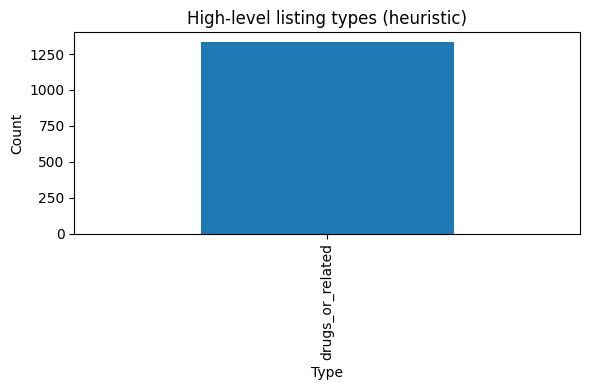

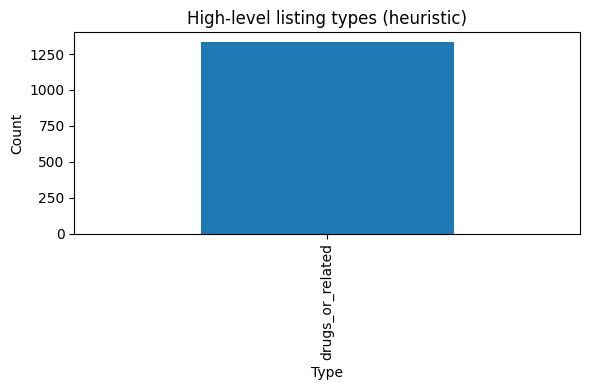

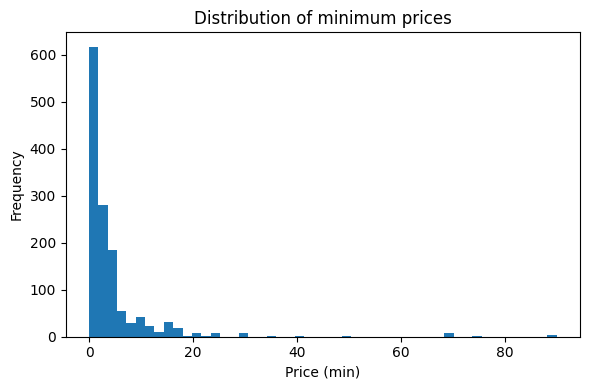

In [9]:
# --- Plot: distribution of high-level types ---
if not df.empty and "high_level_type" in df.columns:
    type_counts = df["high_level_type"].value_counts()
    plt.figure(figsize=(6,4))
    type_counts.plot(kind="bar")
    plt.title("High-level listing types (heuristic)")
    plt.xlabel("Type")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# --- Plot: price distribution (log-scale) ---
if not df.empty and "price_min" in df.columns:
    prices = df["price_min"].dropna()
    if len(prices) > 0:
        plt.figure(figsize=(6,4))
        plt.hist(prices, bins=50)
        plt.title("Distribution of minimum prices")
        plt.xlabel("Price (min)")
        plt.ylabel("Frequency")
        plt.yscale("linear")
        plt.tight_layout()
        plt.show()


In [10]:
# Save parsed metadata to CSV for further analysis
output_csv = DATA_DIR / "nemesis_english_parsed.csv"
df.to_csv(output_csv, index=False)
print(f"Saved parsed metadata to: {output_csv.resolve()}")

Saved parsed metadata to: C:\Users\Nguyen Ngo\Downloads\English\English\textpages\nemesis_english_parsed.csv
